# Feature based time series classification in aeon

Feature based classifiers are a popular recent theme in TSC. The feature
based classifiers we provide are simply pipelines of transform and classifier. They
extract descriptive statistics as features from time series to be used in
classifiers. Several tool-kits exist for extracting features.


<img src="./img/pipeline.png" width="800" alt="Pipeline classifier.">


## Imports and Load Data

In [5]:
import warnings

from sklearn import metrics

from aeon.classification.feature_based import Catch22Classifier, FreshPRINCEClassifier
from aeon.datasets import load_basic_motions, load_italy_power_demand
from aeon.registry import all_estimators
from aeon.transformations.collection.feature_based import Catch22

warnings.filterwarnings("ignore")

X_train, y_train = load_italy_power_demand(split="train")
X_test, y_test = load_italy_power_demand(split="test")
X_test = X_test[:50]
y_test = y_test[:50]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train_mv, y_train_mv = load_basic_motions(split="train")
X_test_mv, y_test_mv = load_basic_motions(split="test")

X_train_mv = X_train_mv[:20]
y_train_mv = y_train_mv[:20]
X_test_mv = X_test_mv[:20]
y_test_mv = y_test_mv[:20]

print(X_train_mv.shape, y_train_mv.shape, X_test_mv.shape, y_test_mv.shape)
all_estimators("classifier", filter_tags={"algorithm_type": "feature"})

[('Catch22Classifier',
  aeon.classification.feature_based._catch22_classifier.Catch22Classifier),
 ('FreshPRINCEClassifier',
  aeon.classification.feature_based._fresh_prince.FreshPRINCEClassifier),
 ('SignatureClassifier',
  aeon.classification.feature_based._signature_classifier.SignatureClassifier),
 ('SummaryClassifier',
  aeon.classification.feature_based._summary_classifier.SummaryClassifier),
 ('TSFreshClassifier',
  aeon.classification.feature_based._tsfresh_classifier.TSFreshClassifier)]

### Catch22 and the Catch22Classifier

The highly comparative time-series analysis (hctsa) [1] toolbox can create over 7700
features for exploratory time series analysis. The canonical time series
characteristics (catch22) [2] are 22 hctsa features determined to be the most
discriminatory of the full  set. The catch22 were chosen by an evaluation on the UCR
datasets. The hctsa features were initially pruned, removing those which are
sensitive to mean and variance and any which could not be calculated on over 80\% of
the UCR  datasets. A feature evaluation was then performed based on predictive
performance. Any features which performed below a threshold were removed. For the
remaining features, a hierarchical clustering was performed on the correlation matrix
 to remove redundancy. From each of the 22 clusters formed, a single feature was
 selected, taking into account balanced accuracy, computational efficiency and
 interpretability. The catch22 features cover a wide range of concepts such as basic
 statistics of data series values, linear correlations, and entropy. Reported results
  for catch22 build a decision tree classifier after applying the transform to each
  data series.

The Catch22Classifier is simply a convenient wrapper for a pipelin of a Catch22
transformation and a sklearn random forest classifier by default.

In [6]:
c22 = Catch22()
x_trans = c22.fit_transform(X_train)
x_trans.shape

(67, 22)

In [7]:
c22cls = Catch22Classifier()
c22cls.fit(X_train, y_train)
c22_preds = c22cls.predict(X_test)
metrics.accuracy_score(y_test, c22_preds)

0.84

### TSFresh and the FreshPRINCEClassifier

Time Series Feature Extraction based on Scalable Hypothesis Tests (TSFresh) is a
collection of just under 800 features extracted from time series. An extensive
comparison of feature based pipelines [3] found that TSFresh followed by a rotation
forest classifier [4] was significantly more accurate than other combinations. This
pipeline is hard coded into an aeon classifier called the FreshPRINCEClassifier.

In [8]:
fp = FreshPRINCEClassifier()
fp.fit(X_train, y_train)
fp_preds = c22cls.predict(X_test)
metrics.accuracy_score(y_test, fp_preds)

0.84

### Signatures and the SignatureClassifier

Generalised signatures are a set of feature extraction techniques primarily for
multivariate time series based on rough path theory. We specifically look at the
generalised signature method [5] and the accompanying canonical signature pipeline.
Signatures are collections of ordered cross-moments. The pipeline begins by applying
two augmentations by default. The basepoint
augmentation simply adds a zero at the beginning of the time series, making the
signature sensitive to translations of the time series. The time augmentation adds
the series timestamps as an extra coordinate to guarantee each signature is unique
and obtain information about the parameterisation of the time series. A hierarchical
dyadic window is run over the series, with the signature transform being applied to
each window. The output for each window is then concatenated into a feature vector.
Signatures requires the installation of the soft dependency esig.

## Performance on the UCR univariate datasets

You can find the dictionary based classifiers as follows.

In [1]:
from aeon.registry import all_estimators

est = all_estimators("classifier", filter_tags={"algorithm_type": "feature"})
for c in est:
    print(c)

('Catch22Classifier', <class 'aeon.classification.feature_based._catch22.Catch22Classifier'>)
('FreshPRINCEClassifier', <class 'aeon.classification.feature_based._fresh_prince.FreshPRINCEClassifier'>)
('SignatureClassifier', <class 'aeon.classification.feature_based._signature_classifier.SignatureClassifier'>)
('SummaryClassifier', <class 'aeon.classification.feature_based._summary_classifier.SummaryClassifier'>)
('TSFreshClassifier', <class 'aeon.classification.feature_based._tsfresh_classifier.TSFreshClassifier'>)


In [3]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_data_lists import univariate

names = [t[0] for t in est]
names.remove("SummaryClassifier")  # Need to evaluate this
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 4)

(<Figure size 600x230 with 1 Axes>, <Axes: >)

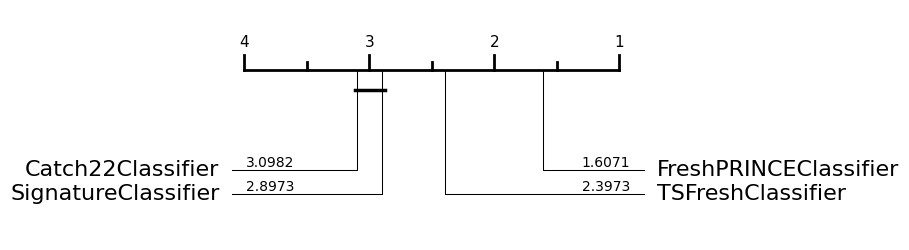

In [4]:
from aeon.visualisation import plot_boxplot_median, plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

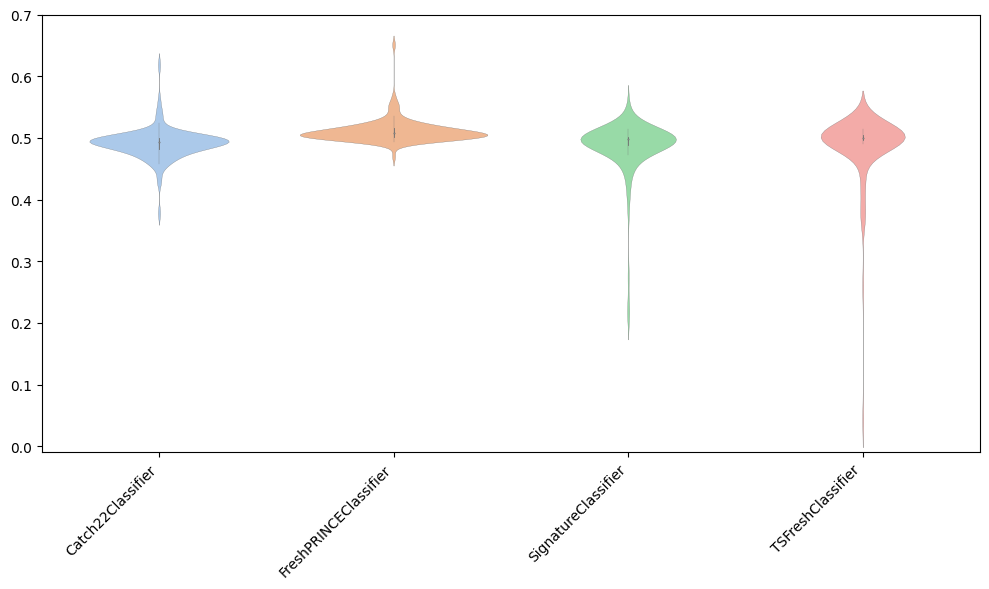

In [5]:
plot_boxplot_median(results, names)

## References

[1]htsc repo https://github.com/benfulcher/hctsa

[2] Christ,  et al.  (2018) "Time series feature extraction on basis of scalable
hypothesis tests (tsfresh–a python package)." Neurocomputing 307: 72-77.
        https://www.sciencedirect.com/science/article/pii/S0925231218304843

[3] Midddlehurst and Bagnall (2022) "The FreshPRINCE: A Simple Transformation Based
Pipeline Time Series Classifier" https://arxiv.org/abs/2201.12048

[4] Rodriguez et al. (2006) "Rotation Forest: A New Classifier Ensemble Method" IEEE
Transactions on Pattern Analysis and Machine Intelligence, 28(10): 1619--1630.

[5] Morrill et al. (2020) "A generalised signature method for multivariate time series
feature extraction" https://arxiv.org/abs/2006.00873
